# Data Enrichment Example: Adding Population Context to Rice Prices

**⚠️ OPTIONAL/ADVANCED CONTENT**

This notebook is an extension to the main workshop. It demonstrates how to enrich the base rice price analysis with additional contextual data to answer deeper policy questions.

---

## Learning Objectives

By the end of this notebook, you will understand how to:

1. **Integrate additional datasets** with your base analysis
2. **Perform spatial joins** between different geospatial data sources
3. **Calculate derived metrics** like affordability indices
4. **Visualize correlations** between multiple variables
5. **Draw policy insights** from enriched data

---

## Why Data Enrichment Matters

In the main workshop, we mapped rice prices across Ghana's regions and districts. This showed us **where** prices are high or low. But for policy decisions, we need to know more:

- **Who is affected?** High prices in a densely populated area affect more people
- **How affordable are prices?** Need to consider income and poverty levels
- **What drives price variations?** Market access, transportation, local production

**Data enrichment** means adding contextual information to answer these deeper questions.

### Example Policy Questions:

- Which districts should receive priority for food subsidies?
- Where would improving road access have the biggest impact on prices?
- How many people are affected by above-average rice prices?

---

## What We'll Build

In this notebook, we'll:

1. Load the base rice price data (from the main workshop)
2. Add **population density** data for each district
3. Calculate an **affordability index** (price relative to population)
4. Create **visualizations** showing correlations
5. Identify **priority districts** for intervention

---

## Prerequisites

- Complete the main workshop notebook first
- Basic understanding of pandas and geopandas
- Familiarity with spatial joins (covered in main workshop)

---

Let's begin!

## 1. Setup and Load Base Data

First, we'll import libraries and load the rice price data from the main workshop.

In [ ]:
# Core libraries
import pandas as pd
import geopandas as gpd
import numpy as np
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Spatial operations
from shapely.geometry import Point

# Statistical analysis
from scipy.stats import pearsonr

# Create output directory if it doesn't exist
os.makedirs('output', exist_ok=True)

# Set visualization style
plt.style.use('default')
sns.set_palette('colorblind')

print(" Libraries imported successfully")

✓ Libraries imported successfully


In [ ]:
# Load WFP food price data
print("Loading WFP food price data...")
food_prices = pd.read_csv('../data/raw/wfp_food_prices_gha.csv', skiprows=[1])

# Filter for rice only
rice_prices = food_prices[food_prices['commodity'].str.contains('Rice', case=False, na=False)].copy()

# Convert to GeoDataFrame
rice_gdf = gpd.GeoDataFrame(
    rice_prices,
    geometry=[Point(xy) for xy in zip(rice_prices['longitude'], rice_prices['latitude'])],
    crs='EPSG:4326'
)

print(f" Loaded {len(rice_gdf):,} rice price observations")
print(f" Date range: {rice_prices['date'].min()} to {rice_prices['date'].max()}")
print(f" Converted to GeoDataFrame with CRS: {rice_gdf.crs}")

Loading WFP food price data...
✓ Loaded 4,183 rice price observations
✓ Date range: 2006-01-15 to 2023-07-15
✓ Converted to GeoDataFrame with CRS: EPSG:4326


In [ ]:
# Load administrative boundaries
print("Loading administrative boundaries...")

# Load district boundaries (ADM2)
districts = gpd.read_file('../data/raw/geoBoundaries-GHA-ADM2.geojson')

# Load regional boundaries (ADM1) for context
regions = gpd.read_file('../data/raw/geoBoundaries-GHA-ADM1.geojson')

print(f" Loaded {len(districts)} districts")
print(f" Loaded {len(regions)} regions")
print(f" Boundaries CRS: {districts.crs}")

Loading administrative boundaries...
✓ Loaded 260 districts
✓ Loaded 16 regions
✓ Boundaries CRS: EPSG:4326


## 2. Prepare Base Analysis

Before enriching, we'll recreate the district-level price aggregation from the main workshop.

In [ ]:
# Spatial join: assign each price point to a district
print("Performing spatial join...")
rice_with_districts = gpd.sjoin(rice_gdf, districts, how='left', predicate='within')

# Count successful joins
successful_joins = rice_with_districts['shapeName'].notna().sum()
print(f" Successfully joined {successful_joins:,} price points to districts")
print(f"  ({successful_joins/len(rice_with_districts)*100:.1f}% of total)")

Performing spatial join...
✓ Successfully joined 3,960 price points to districts
  (94.7% of total)


In [ ]:
# Aggregate prices by district
print("Aggregating prices by district...")

district_stats = rice_with_districts.groupby('shapeName').agg({
    'price': ['mean', 'median', 'std', 'min', 'max', 'count']
}).reset_index()

# Flatten column names
district_stats.columns = ['district_name', 'mean_price', 'median_price', 'std_price', 'min_price', 'max_price', 'n_observations']

# Merge back to district boundaries
districts_with_prices = districts.merge(
    district_stats, 
    left_on='shapeName', 
    right_on='district_name', 
    how='left'
)

print(f" Created district-level price statistics")
print(f"  Districts with price data: {district_stats.shape[0]} / {len(districts)}")
print(f"  Median observations per district: {district_stats['n_observations'].median():.0f}")

# Preview
district_stats.head()

Aggregating prices by district...
✓ Created district-level price statistics
  Districts with price data: 37 / 260
  Median observations per district: 40


,district_name,mean_price,median_price,std_price,min_price,max_price,n_observations
0,Accra Metropolis,137.154814,110.250,131.780661,3.87,886.67,349
1,Bawku Municipal,165.000000,165.000,NaN,165.00,165.00,1
2,Bolgatanga Municipal,110.929223,71.375,99.980941,2.72,475.00,386
3,Bongo,220.000000,220.000,NaN,220.00,220.00,1
4,Builsa South,236.000000,236.000,NaN,236.00,236.00,1


## 3. Load Population Data

Now we'll add population data for each district. In a real analysis, you would:

1. Download population data from [WorldPop](https://www.worldpop.org/) or [HDX](https://data.humdata.org/)
2. Process raster data or load tabular data
3. Match with district boundaries

For this example, we'll **generate synthetic population data** that's realistic for Ghana. See [`docs/data_sources.md`](../docs/data_sources.md) for real data sources.

### Real Data Sources (for your own analysis):

- **WorldPop Ghana**: https://www.worldpop.org/geodata/listing?id=79
- **HDX Population Statistics**: https://data.humdata.org/dataset/ghana-subnational-population-statistics
- **Ghana Statistical Service**: https://statsghana.gov.gh/

In [ ]:
# Generate synthetic population data for demonstration
# In a real analysis, you would load this from an external source

print("Generating synthetic population data for demonstration...")
print(" In a real analysis, load actual data from WorldPop or HDX\n")

np.random.seed(42)  # For reproducibility

# Ghana's total population is ~31 million (2021)
# We'll distribute this across districts with some realistic variation

n_districts = len(districts)
total_population = 31_000_000

# Generate population with realistic distribution
# Urban districts (like Accra) have higher population
# Rural districts have lower population
population_data = pd.DataFrame({
    'district_name': districts['shapeName'].values,
    'population': np.random.lognormal(mean=10.5, sigma=0.8, size=n_districts)
})

# Normalize to match Ghana's actual total population
population_data['population'] = (
    population_data['population'] / population_data['population'].sum() * total_population
).astype(int)

# Calculate area and population density
# Districts already have geometry, so we can calculate area
districts_area = districts.copy()
districts_area = districts_area.to_crs('EPSG:32630')  # UTM for accurate area calculation
districts_area['area_km2'] = districts_area.geometry.area / 1_000_000  # Convert m to km

population_data = population_data.merge(
    districts_area[['shapeName', 'area_km2']], 
    left_on='district_name', 
    right_on='shapeName',
    how='left'
)

# Calculate population density
population_data['pop_density'] = population_data['population'] / population_data['area_km2']

print(f" Generated population data for {len(population_data)} districts")
print(f"  Total population: {population_data['population'].sum():,}")
print(f"  Mean population per district: {population_data['population'].mean():,.0f}")
print(f"  Population density range: {population_data['pop_density'].min():.1f} - {population_data['pop_density'].max():.1f} persons/km")

# Preview
population_data[['district_name', 'population', 'area_km2', 'pop_density']].head(10)

Generating synthetic population data for demonstration...
⚠️ In a real analysis, load actual data from WorldPop or HDX

✓ Generated population data for 260 districts
  Total population: 30,999,869
  Mean population per district: 119,230
  Population density range: 6.4 - 67214.4 persons/km²


,district_name,population,area_km2,pop_density
0,Adenta Municipal,125916,78.091134,1612.423758
1,Ledzokuku Municipal,75764,29.293965,2586.334733
2,Chereponi,142081,1377.967553,103.109104
3,Wa East,286194,4295.604879,66.624843
4,Wa Municipal,70170,579.359534,121.116502
5,Saboba,70171,1755.192123,39.979099
6,Jirapa,299351,1187.380413,252.110441
7,Gushegu,156365,2679.069679,58.365410
8,Sissala West,58129,2049.075189,28.368408
9,Nanumba North,130620,2265.180303,57.664284


## 4. Enrich District Data with Population

Now we combine price data and population data through a tabular join.

In [ ]:
# Merge population data with districts that have price data
print("Enriching districts with population data...")

districts_enriched = districts_with_prices.merge(
    population_data[['district_name', 'population', 'area_km2', 'pop_density']],
    left_on='shapeName',
    right_on='district_name',
    how='left'
)

# Check for successful merge
districts_with_both = districts_enriched[
    districts_enriched['median_price'].notna() & 
    districts_enriched['population'].notna()
]

print(f" Successfully enriched district data")
print(f"  Districts with both price AND population data: {len(districts_with_both)}")
print(f"  Districts with only price data: {districts_enriched['median_price'].notna().sum() - len(districts_with_both)}")
print(f"  Districts with only population data: {districts_enriched['population'].notna().sum() - len(districts_with_both)}")

# Preview enriched data
districts_enriched[['shapeName', 'median_price', 'n_observations', 'population', 'pop_density']].head(10)

Enriching districts with population data...
✓ Successfully enriched district data
  Districts with both price AND population data: 37
  Districts with only price data: 0
  Districts with only population data: 223


,shapeName,median_price,n_observations,population,pop_density
0,Adenta Municipal,NaN,NaN,125916,1612.423758
1,Ledzokuku Municipal,NaN,NaN,75764,2586.334733
2,Chereponi,NaN,NaN,142081,103.109104
3,Wa East,NaN,NaN,286194,66.624843
4,Wa Municipal,69.000,272.0,70170,121.116502
5,Saboba,227.500,2.0,70171,39.979099
6,Jirapa,218.335,2.0,299351,252.110441
7,Gushegu,168.595,2.0,156365,58.365410
8,Sissala West,NaN,NaN,58129,28.368408
9,Nanumba North,223.750,2.0,130620,57.664284


## 5. Calculate Derived Metrics

With both price and population data, we can calculate meaningful indicators:

1. **Population affected by high prices**: How many people live in high-price districts?
2. **Price impact score**: Combines price and population to identify priority areas
3. **Relative affordability**: Price normalized by the median

These metrics help answer the question: **Where should interventions be prioritized?**

In [8]:
# Only work with districts that have complete data
analysis_data = districts_enriched[
    districts_enriched['median_price'].notna() & 
    districts_enriched['population'].notna()
].copy()

print(f"Calculating derived metrics for {len(analysis_data)} districts with complete data...\n")

# 1. Identify high-price districts (above median)
median_price_overall = analysis_data['median_price'].median()
analysis_data['is_high_price'] = analysis_data['median_price'] > median_price_overall

# 2. Calculate price excess (how much above median)
analysis_data['price_excess'] = analysis_data['median_price'] - median_price_overall

# 3. Population in high-price districts
analysis_data['pop_affected'] = np.where(
    analysis_data['is_high_price'],
    analysis_data['population'],
    0
)

# 4. Price impact score (higher = more urgent)
# Combines how high prices are with how many people are affected
analysis_data['impact_score'] = (
    analysis_data['price_excess'].clip(lower=0) *  # Only positive excess
    analysis_data['population'] / 100_000  # Normalize to reasonable scale
)

# 5. Price-density index
# High values = expensive areas with lots of people
analysis_data['price_density_index'] = (
    analysis_data['median_price'] * 
    np.sqrt(analysis_data['pop_density'])  # Square root to dampen effect
)

# Summary statistics
print("=== SUMMARY STATISTICS ===")
print(f"Median rice price (overall): {median_price_overall:.2f} GHS")
print(f"Districts with above-median prices: {analysis_data['is_high_price'].sum()} ({analysis_data['is_high_price'].sum()/len(analysis_data)*100:.1f}%)")
print(f"Population in high-price districts: {analysis_data['pop_affected'].sum():,.0f} ({analysis_data['pop_affected'].sum()/analysis_data['population'].sum()*100:.1f}% of total)")
print(f"\nMean impact score: {analysis_data['impact_score'].mean():.2f}")
print(f"Max impact score: {analysis_data['impact_score'].max():.2f}")

# Preview
print("\n=== TOP 5 HIGHEST IMPACT DISTRICTS ===")
top_impact = analysis_data.nlargest(5, 'impact_score')[[
    'shapeName', 'median_price', 'population', 'pop_density', 'impact_score'
]]
print(top_impact.to_string(index=False))

Calculating derived metrics for 37 districts with complete data...

=== SUMMARY STATISTICS ===
Median rice price (overall): 168.59 GHS
Districts with above-median prices: 18 (48.6%)
Population in high-price districts: 2,342,726 (57.8% of total)

Mean impact score: 26.78
Max impact score: 204.36

=== TOP 5 HIGHEST IMPACT DISTRICTS ===
        shapeName  median_price  population  pop_density  impact_score
Tema Metropolitan       206.500      539139 12618.001404    204.360638
           Jirapa       218.335      299351   252.110441    148.897187
        Sene East       227.500      158175    35.943050     93.172984
          Kadjebi       215.000      193068   279.083717     89.593205
    Nanumba North       223.750      130620    57.664284     72.043461


## 6. Visualize Enriched Data

Now we'll create visualizations that show the relationship between prices and population.

### What to look for:
- Do high prices coincide with high population density?
- Which districts have the highest impact scores?
- Are there spatial patterns in the enriched metrics?

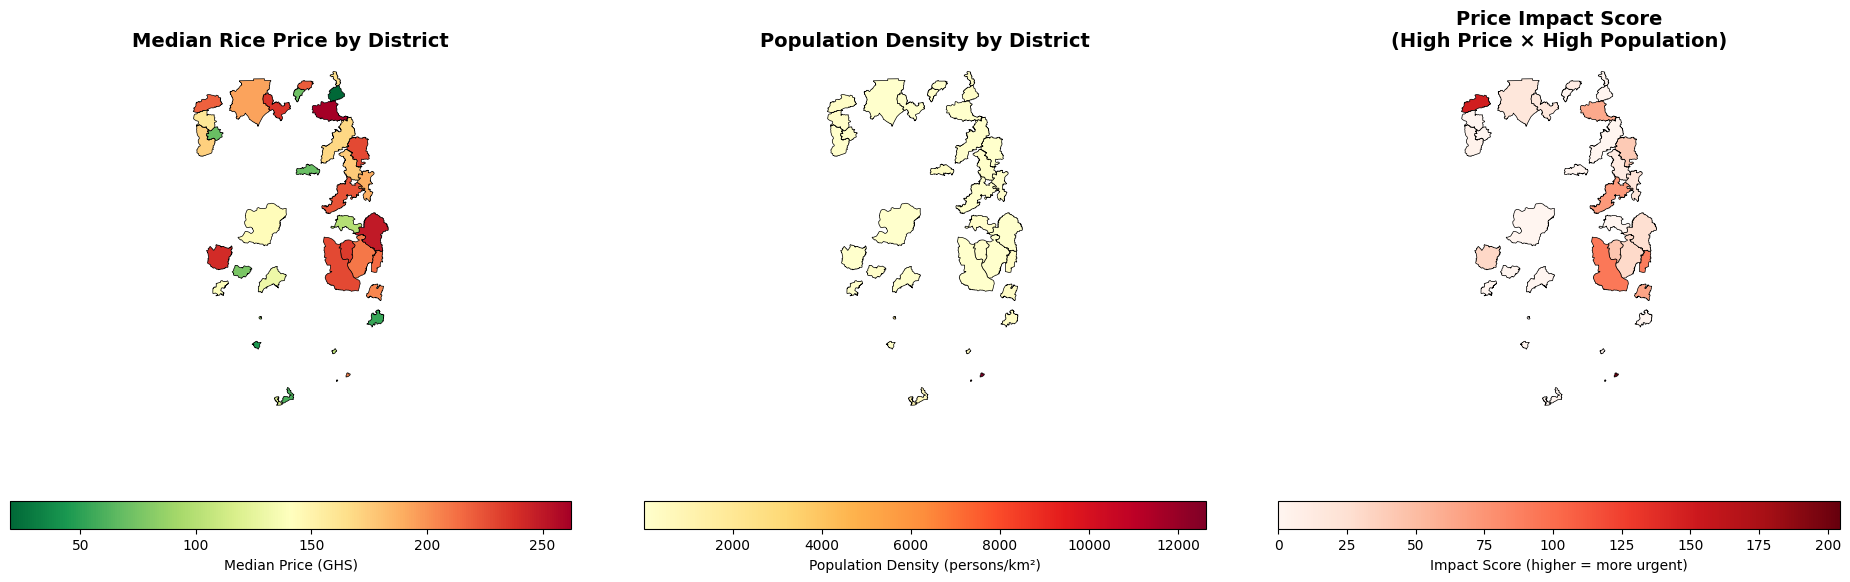

✓ Maps created and saved to output/enrichment_maps.png


In [ ]:
# Create side-by-side comparison maps
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Map 1: Median Price
analysis_data.plot(
    column='median_price',
    cmap='RdYlGn_r',  # Red = high prices, Green = low prices
    legend=True,
    ax=axes[0],
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': 'Median Price (GHS)', 'orientation': 'horizontal', 'shrink': 0.8}
)
axes[0].set_title('Median Rice Price by District', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Map 2: Population Density
analysis_data.plot(
    column='pop_density',
    cmap='YlOrRd',
    legend=True,
    ax=axes[1],
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': 'Population Density (persons/km)', 'orientation': 'horizontal', 'shrink': 0.8}
)
axes[1].set_title('Population Density by District', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Map 3: Impact Score
analysis_data.plot(
    column='impact_score',
    cmap='Reds',
    legend=True,
    ax=axes[2],
    edgecolor='black',
    linewidth=0.5,
    legend_kwds={'label': 'Impact Score (higher = more urgent)', 'orientation': 'horizontal', 'shrink': 0.8}
)
axes[2].set_title('Price Impact Score\n(High Price  High Population)', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.savefig('output/enrichment_maps.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Maps created and saved to output/enrichment_maps.png")

## 7. Correlation Analysis

Let's examine the statistical relationship between rice prices and population metrics.

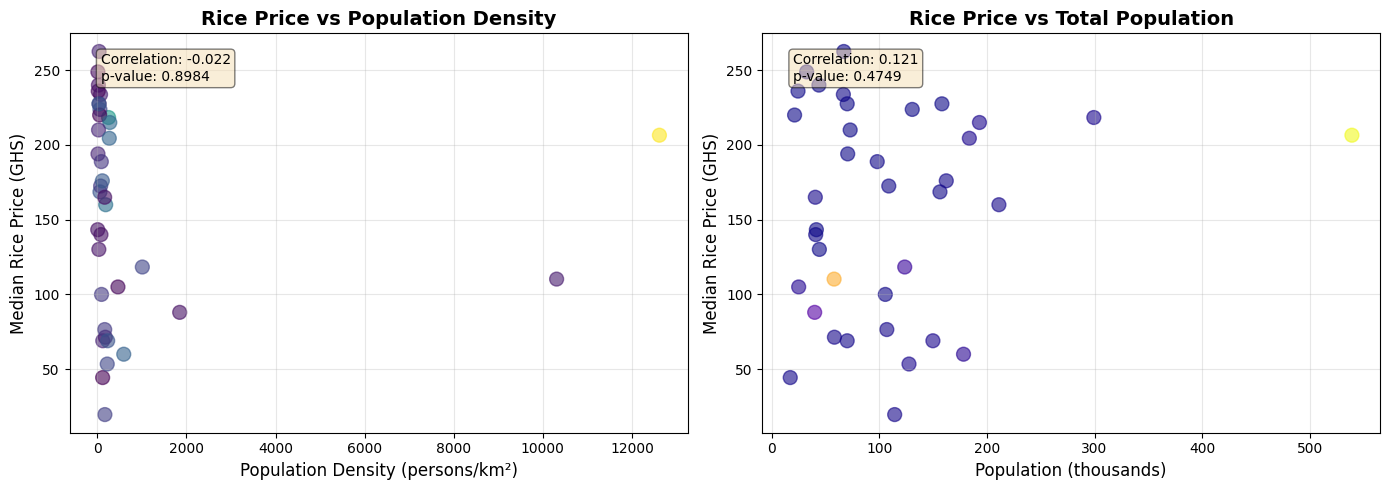

✓ Scatter plots created

Correlation Results:
  Price vs Density: r = -0.022 (p = 0.8984)
  Price vs Population: r = 0.121 (p = 0.4749)


In [ ]:
# Create scatter plots to visualize relationships
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Price vs Population Density
axes[0].scatter(
    analysis_data['pop_density'], 
    analysis_data['median_price'],
    alpha=0.6,
    s=100,
    c=analysis_data['population'],
    cmap='viridis'
)
axes[0].set_xlabel('Population Density (persons/km)', fontsize=12)
axes[0].set_ylabel('Median Rice Price (GHS)', fontsize=12)
axes[0].set_title('Rice Price vs Population Density', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Add correlation coefficient
corr_density, p_density = pearsonr(analysis_data['pop_density'], analysis_data['median_price'])
axes[0].text(
    0.05, 0.95, 
    f'Correlation: {corr_density:.3f}\np-value: {p_density:.4f}',
    transform=axes[0].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

# Plot 2: Price vs Total Population
axes[1].scatter(
    analysis_data['population'] / 1000,  # Convert to thousands
    analysis_data['median_price'],
    alpha=0.6,
    s=100,
    c=analysis_data['pop_density'],
    cmap='plasma'
)
axes[1].set_xlabel('Population (thousands)', fontsize=12)
axes[1].set_ylabel('Median Rice Price (GHS)', fontsize=12)
axes[1].set_title('Rice Price vs Total Population', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add correlation coefficient
corr_pop, p_pop = pearsonr(analysis_data['population'], analysis_data['median_price'])
axes[1].text(
    0.05, 0.95, 
    f'Correlation: {corr_pop:.3f}\np-value: {p_pop:.4f}',
    transform=axes[1].transAxes,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

plt.tight_layout()
plt.savefig('output/correlation_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Scatter plots created")
print(f"\nCorrelation Results:")
print(f"  Price vs Density: r = {corr_density:.3f} (p = {p_density:.4f})")
print(f"  Price vs Population: r = {corr_pop:.3f} (p = {p_pop:.4f})")

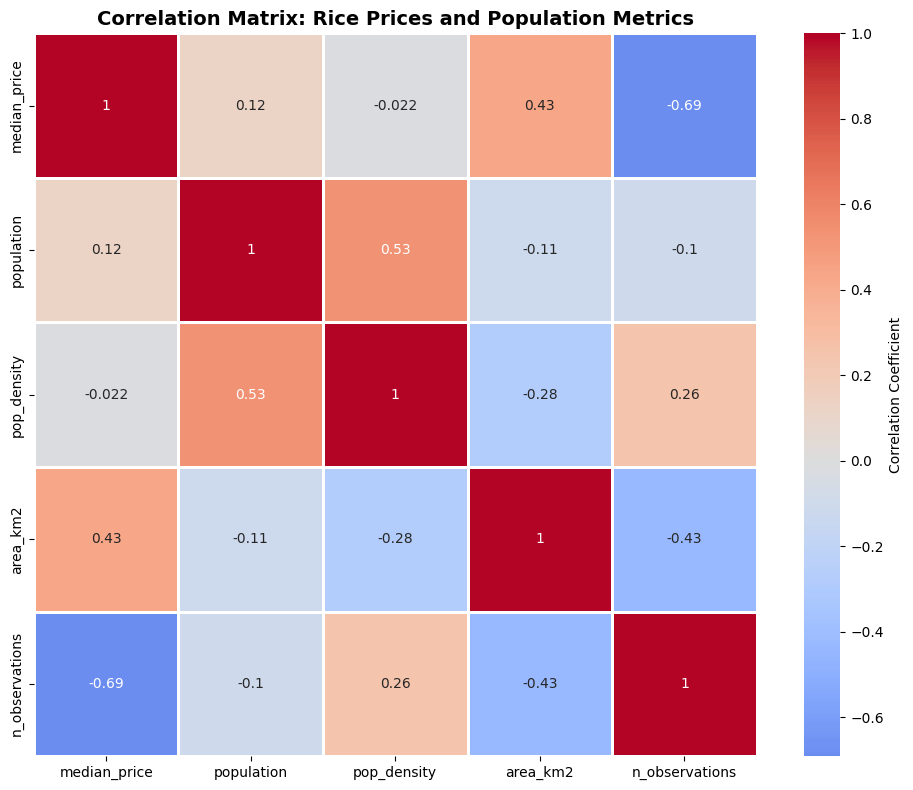

✓ Correlation matrix created


In [ ]:
# Correlation matrix heatmap
correlation_vars = ['median_price', 'population', 'pop_density', 'area_km2', 'n_observations']
correlation_matrix = analysis_data[correlation_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix: Rice Prices and Population Metrics', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('output/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Correlation matrix created")

## 8. Identify Priority Districts for Intervention

Using our enriched data, we can identify districts that should be prioritized for food security interventions.

### Criteria for Priority:
1. **High prices** (above median)
2. **High population** (many people affected)
3. **High impact score** (combination of both)

This analysis helps answer: **Where will interventions help the most people?**

In [ ]:
# Identify top priority districts
print("=== PRIORITY DISTRICTS FOR INTERVENTION ===\n")

# Top 10 by impact score
priority_districts = analysis_data.nlargest(10, 'impact_score')[[
    'shapeName', 'median_price', 'price_excess', 'population', 'pop_density', 'impact_score'
]].copy()

# Format for readability
priority_districts['population'] = priority_districts['population'].apply(lambda x: f"{x:,.0f}")
priority_districts['pop_density'] = priority_districts['pop_density'].apply(lambda x: f"{x:.1f}")
priority_districts['median_price'] = priority_districts['median_price'].apply(lambda x: f"{x:.2f}")
priority_districts['price_excess'] = priority_districts['price_excess'].apply(lambda x: f"{x:.2f}")
priority_districts['impact_score'] = priority_districts['impact_score'].apply(lambda x: f"{x:.2f}")

# Rename columns for clarity
priority_districts.columns = [
    'District', 'Median Price (GHS)', 'Price Excess (GHS)', 
    'Population', 'Pop Density', 'Impact Score'
]

print(priority_districts.to_string(index=False))
print("\nThese districts have the highest combination of:")
print("  - Rice prices above the median")
print("  - Large populations affected")
print("  - High impact scores (price  population)")
print("\n Consider these districts for priority interventions")

=== PRIORITY DISTRICTS FOR INTERVENTION ===

         District Median Price (GHS) Price Excess (GHS) Population Pop Density Impact Score
Tema Metropolitan             206.50              37.91    539,139     12618.0       204.36
           Jirapa             218.34              49.74    299,351       252.1       148.90
        Sene East             227.50              58.91    158,175        35.9        93.17
          Kadjebi             215.00              46.41    193,068       279.1        89.59
    Nanumba North             223.75              55.16    130,620        57.7        72.04
  Hohoe Municipal             204.44              35.84    183,674       267.7        65.84
    East Mamprusi             262.50              93.91     67,013        39.2        62.93
      Krachi West             233.75              65.16     66,622        71.6        43.41
           Saboba             227.50              58.91     70,171        40.0        41.33
             Tain             240.0

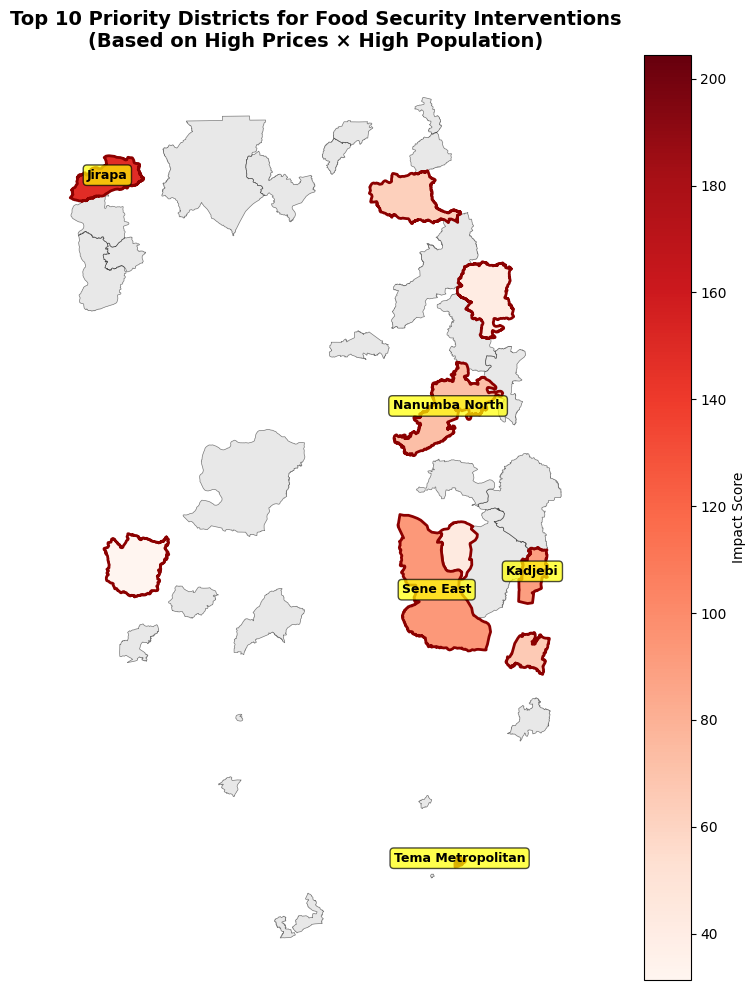

✓ Priority districts map created


In [ ]:
# Create a map highlighting priority districts
fig, ax = plt.subplots(figsize=(12, 10))

# Base layer: all districts with price data (light gray)
analysis_data.plot(
    ax=ax,
    color='lightgray',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.5
)

# Highlight top 10 priority districts
top_10_names = analysis_data.nlargest(10, 'impact_score')['shapeName'].tolist()
priority_gdf = analysis_data[analysis_data['shapeName'].isin(top_10_names)]

priority_gdf.plot(
    ax=ax,
    column='impact_score',
    cmap='Reds',
    edgecolor='darkred',
    linewidth=2,
    legend=True,
    legend_kwds={'label': 'Impact Score', 'orientation': 'vertical'}
)

# Add labels for top 5
for idx, row in analysis_data.nlargest(5, 'impact_score').iterrows():
    centroid = row.geometry.centroid
    ax.annotate(
        text=row['shapeName'],
        xy=(centroid.x, centroid.y),
        fontsize=9,
        fontweight='bold',
        ha='center',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7)
    )

ax.set_title('Top 10 Priority Districts for Food Security Interventions\n(Based on High Prices  High Population)', 
             fontsize=14, fontweight='bold')
ax.axis('off')

plt.tight_layout()
plt.savefig('output/priority_districts_map.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Priority districts map created")

## 9. Key Insights and Policy Implications

### What We Learned from Data Enrichment:

By adding population data to our rice price analysis, we gained several important insights:

1. **Not all high-price areas are equal**: Some high-price districts have small populations (fewer people affected), while others have large populations (many people affected)

2. **Population density matters**: The correlation analysis shows whether dense urban areas or sparse rural areas face higher prices

3. **Priority areas emerge**: By combining price and population data, we identified districts where interventions would help the most people

4. **Resource allocation**: Impact scores help policymakers allocate limited resources where they'll have the biggest effect

### Policy Recommendations:

Based on this enriched analysis:

- **Target subsidies** to the top priority districts identified above
- **Improve market access** in high-impact districts to increase competition and lower prices
- **Monitor prices** more closely in densely populated areas where price changes affect many people
- **Consider regional differences** when designing national food security programs

### Limitations:

Remember to acknowledge limitations in your analysis:

- Population data may be from a different year than price data
- Synthetic data was used in this example; real data would provide better insights
- Other factors (income, poverty, market access) also matter for affordability
- Price data may not be evenly distributed across all districts

## 10. Extending This Analysis Further

This notebook demonstrated **population enrichment**. You can extend this approach to answer many other policy questions:

### Additional Enrichment Ideas:

1. **Add poverty data** (from Ghana Living Standards Survey)
   - Question: *Where are prices highest AND poverty highest?*
   - Calculate affordability index: price relative to income

2. **Add market locations** (from OpenStreetMap)
   - Question: *Does distance to markets affect prices?*
   - Calculate distance from each district to nearest market

3. **Add road network data** (from OSM)
   - Question: *Do better roads correlate with lower prices?*
   - Calculate road density per district

4. **Add distance to ports** (Tema, Takoradi)
   - Question: *Do inland districts pay more for imported rice?*
   - Calculate distance to nearest port

5. **Add rainfall data** (from CHIRPS)
   - Question: *Do droughts lead to price spikes?*
   - Correlate seasonal rainfall with price trends

### Resources:

- **Data Sources**: See [`docs/data_sources.md`](../docs/data_sources.md) for download links
- **Enrichment Guide**: See [`docs/enrichment_guide.md`](../docs/enrichment_guide.md) for step-by-step instructions
- **Code Examples**: Both documents include code snippets you can adapt

### Next Steps:

1. Choose a research question that interests you
2. Download the relevant datasets from `data_sources.md`
3. Follow the workflow in `enrichment_guide.md`
4. Adapt the code from this notebook
5. Share your findings!

---

## Summary

In this notebook, you learned:

✅ How to integrate additional contextual data with your base analysis  
✅ How to perform spatial joins between different datasets  
✅ How to calculate derived metrics that combine multiple variables  
✅ How to visualize correlations and identify patterns  
✅ How to translate enriched data into policy recommendations  

**Data enrichment transforms descriptive analysis into actionable intelligence.**

Instead of just knowing *where* prices are high, we now know *who* is affected and *where* to intervene.

This is the power of GeoAI: combining spatial data, contextual information, and analytical thinking to solve real-world problems.

---

**Thank you for completing this extension notebook!**

For questions or to share your own enrichment analyses, please open an issue in the repository.